In [1]:
%load_ext cython
import cbc, cbc_dp
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pyqtgraph as pg
import pickle
import multiprocessing
import pygmo
from numpy import ma
from scipy import constants
from scipy.ndimage import median_filter, label, labeled_comprehension, binary_fill_holes, binary_closing
from scipy.ndimage import binary_dilation
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cor_path = "exp_results/scan_{0:05}/scan_streaks_{0:05}.h5"
cor_data_path = 'corrected_data/corrected_data'
streaks_mask_path = 'corrected_data/streaks_mask'
bgd_path = 'corrected_data/background'
data_path = 'data/data'
mask_path = 'data/mask'

with h5py.File(cor_path.format(135), 'r') as f135:
    b12_cor_data = f135[cor_data_path][...]
    b12_streaks_mask = f135[streaks_mask_path][...]
    b12_data = f135[data_path][...]
    b12_mask = f135[mask_path][...]
    b12_bgd = f135[bgd_path][...] * cbc_dp.utils.HOTMASK
frame_shape = b12_mask.shape

In [3]:
pix_size = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
axis = np.array([0., 1., 0.])
f_pos = np.array([120.075, 132.45, 129.1])
pupil = np.array([[1515, 1675], [1557, 1748]])
b12_pos = np.array([119.27333163, 131.87979123, 105.91419768])
lys_pos = np.array([1480 * pix_size, 1155 * pix_size, 150.0])
pupil_size = np.radians([0.65, 1.05])
thetas = np.radians(np.arange(101))

In [4]:
rb_0 = cbc_dp.RecBasis.import_ini('b12_rb_00.ini')
rb_1 = cbc_dp.RecBasis.import_ini('b12_rb_01.ini')
rb_2 = cbc_dp.RecBasis.import_ini('b12_rb_02.ini')

b12_rb_sizes = wavelength / np.array([16.18, 21.23, 24.33]) * 1e7
b12_sset = cbc_dp.ScanSetup.import_ini('b12_geom_00.ini')

In [5]:
with h5py.File(cor_path.format(135), 'r') as f135:
    b12_scan = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][...],
                                  exp_set=b12_sset,
                                  frame_idxs=f135['streaks/frame_idxs'][...])
b12_qs = b12_scan.kout_ref()
basis_f = b12_qs.index()
rb_f = cbc.rec_basis(basis_f)
b12_scan.size

13099

# Data processing pipeline

In [42]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def index_kout_lines(float_t[:, :, ::1] vot_vec, float_t num_ap_x, float_t num_ap_y):
    """
    Return source lines coordinates for a diffraction streaks model

    source - source line origins
    rec_vec - reciprocal vectors
    num_ap_x, num_ap_y - numerical apertires in x- and y-axes
    """
    cdef:
        int a = vot_vec.shape[0], b = vot_vec.shape[1], kk, i, j, k
        uint8_t[:, ::1] mask = np.zeros((a, b), dtype=np.uint8)
        float_t rec_abs, source_phi, source_th, source_x, source_y, source_z
        float_t source_prd, coeff1, coeff2, alpha, betta, gamma, delta, sol_1, sol_2
        float_t[::1] bounds = np.array([num_ap_x, -num_ap_x, num_ap_y, -num_ap_y], dtype=np.float64)
        float_t[:, :, :, ::1] source_lines = np.zeros((a, b, 2, 3), dtype=np.float64)
    for i in range(a):
        for j in range(b):
            rec_abs = sqrt(vot_vec[i, j, 0]**2 + vot_vec[i, j, 1]**2 + vot_vec[i, j, 2]**2)
            source_phi = atan2(vot_vec[i, j, 1], vot_vec[i, j, 0])
            source_th = acos(-vot_vec[i, j, 2] / rec_abs) - acos(rec_abs / 2)
            source_x = -sin(source_th) * cos(source_phi)
            source_y = -sin(source_th) * sin(source_phi)
            source_z =  cos(source_th)
            source_prd = source_x * vot_vec[i, j, 0] + source_y * vot_vec[i, j, 1] + source_z * vot_vec[i, j, 2]
            kk = 0
            for k in range(4):
                coeff1 = source_prd - bounds[k] * vot_vec[i, j, k // 2]
                coeff2 = vot_vec[i, j, (3 - k) // 2]
                alpha = coeff2**2 + vot_vec[i, j, 2]**2
                betta = coeff2 * coeff1
                gamma = coeff1**2 - vot_vec[i, j, 2]**2 * (1 - bounds[k]**2)
                delta = betta**2 - alpha * gamma
                sol_1 = (betta + sqrt(delta)) / alpha
                sol_2 = (betta - sqrt(delta)) / alpha
                if abs(sol_1) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_1
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_1**2)
                    kk += 1
                if delta != 0 and abs(sol_2) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_2
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_2**2)
                    kk += 1
                if kk == 2:
                    mask[i, j] = 1
                    break
    return np.asarray(source_lines), np.asarray(mask).astype(bool)

In [217]:
bad_mask = np.load('cbc_dp/utils/b12_mask.npy')
with h5py.File("exp_results/scan_{0:05}/scan_raw_{0:05}.h5".format(134), 'r') as file:
    exp_bgd = file['data/data'][0]
scan = cbc_dp.open_scan('b12_2', 135)

In [218]:
cor_data = cbc_dp.CorrectedData(b12_data, exp_bgd, bad_mask)

In [38]:
cbc_dp.CorrectedData.streak_width = 13
cor_data._mask_data()

In [263]:
norm_data = cbc_dp.NormalizedData(b12_cor_data, b12_streaks_mask)

In [245]:
line_detector = cbc_dp.LineSegmentDetector(scale=0.5, sigma_scale=0.5)
b12_scan = line_detector.det_scan(norm_data.norm_data, b12_exp, 10)
b12_scan.size

13099

In [248]:
out_file = scan._create_outfile(tag='streaks')
scan._save_parameters(out_file)
scan._save_data(out_file)
cor_data.save(out_file)
b12_scan.save(out_file)
out_file.close()

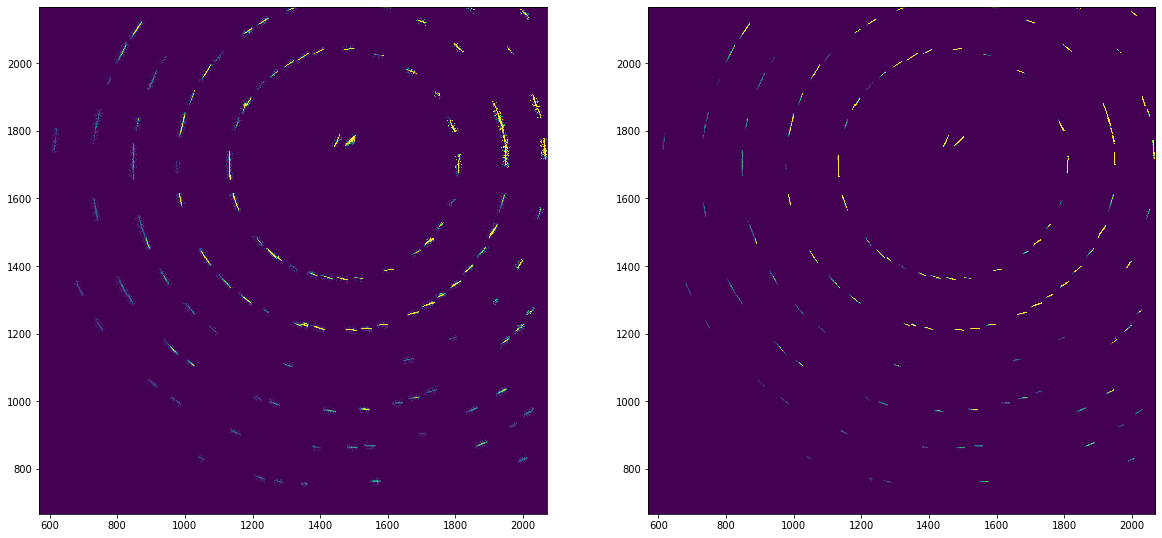

In [37]:
%matplotlib inline
frame_idx = 0
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[frame_idx] * b12_streaks_mask[frame_idx], vmin=0, vmax=50)
axes[1].imshow(b12_cor_data[frame_idx] * streaks_mask(b12_scan[frame_idx].raw_lines,
                                                      structure=cbc_dp.utils.STRUCT,
                                                      width=1, shape_x=frame_shape[0],
                                                      shape_y=frame_shape[1]), vmin=0, vmax=50)
for ax in axes:
    ax.set_xlim(570, 2070)
    ax.set_ylim(667, 2167)
plt.show()
# plt.savefig('figures/norm_frame.pdf')

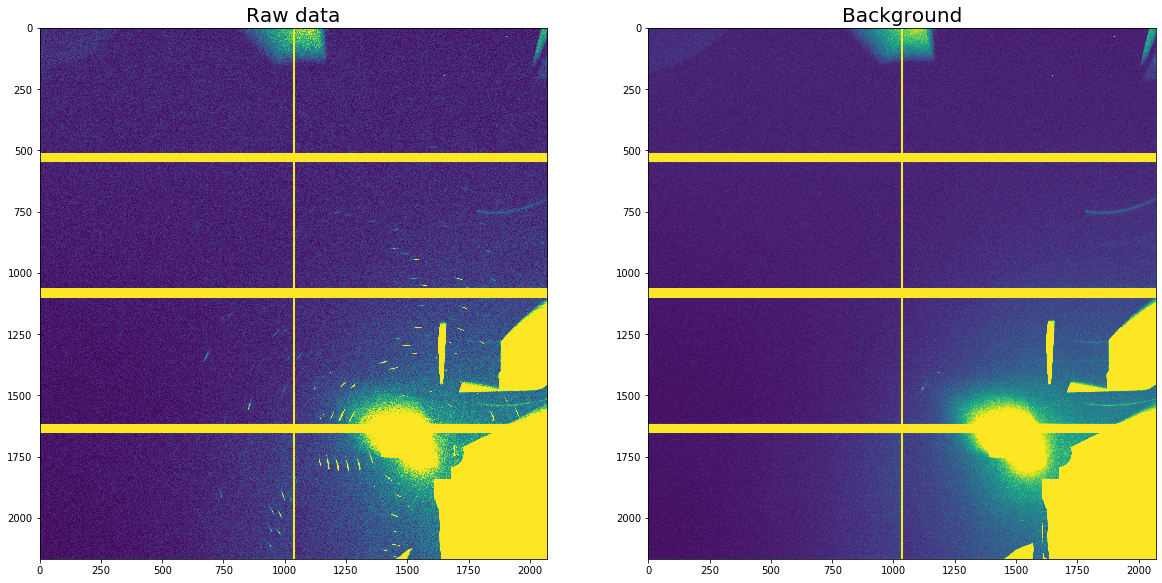

In [23]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_data[frame_idx], vmin=0, vmax=50)
axes[0].set_title('Raw data', fontsize=20)
axes[1].imshow(b12_bgd[frame_idx], vmin=0, vmax=50)
axes[1].set_title('Background', fontsize=20)
plt.show()
# plt.savefig('figures/dp_pipeline1.pdf')

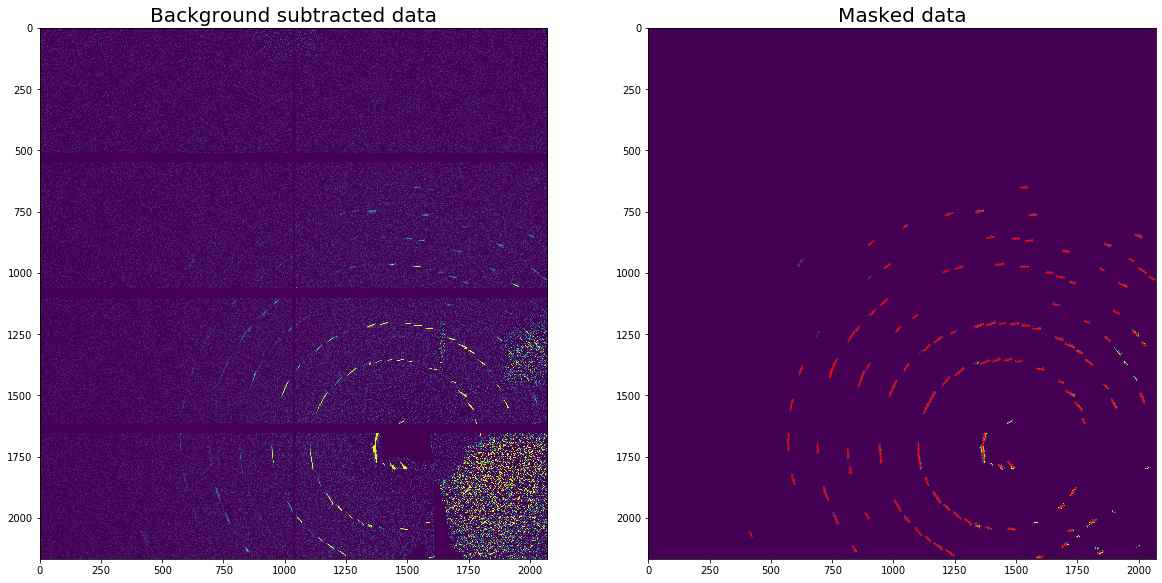

In [82]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[frame_idx], vmin=0, vmax=50)
axes[0].set_title('Background subtracted data', fontsize=20)
axes[1].imshow(b12_cor_data[frame_idx] * b12_streaks_mask[frame_idx], vmin=0, vmax=50)
axes[1].set_title('Masked data', fontsize=20)
for line in b12_scan[frame_idx].raw_lines:
    axes[1].plot(line[:, 0], line[:, 1], 'r')
plt.show()
# plt.savefig('figures/dp_pipeline2.pdf')

# Experimental geometry

In [280]:
frame_idx = 80
pupil = np.array([[1515, 1675], [1558, 1750]])
imax = b12_bgd[frame_idx, pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]].max()
ii, jj = np.where(b12_bgd[frame_idx, pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]] > imax / 10)
ii.min(), ii.max(), jj.min(), jj.max()

(24, 73, 3, 41)

In [11]:
pupil_list = []
for bgd in b12_bgd:
    imax = bgd[pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]].max()
    ii, jj = np.where(bgd[pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]] > imax / 5)
    frame_pupil = np.array([[jj.min(), ii.min()], [jj.max(), ii.max()]])
    pupil_list.append(frame_pupil)
scan_pupil = (np.stack(pupil_list) + pupil[0])

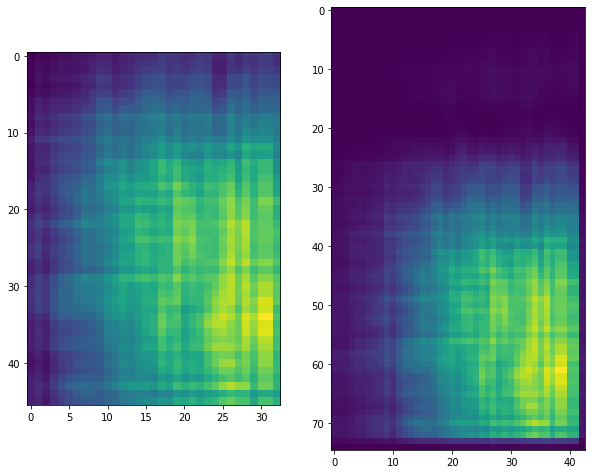

In [299]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(b12_bgd[frame_idx, scan_pupil[frame_idx, 0, 1]:scan_pupil[frame_idx, 1, 1],
                       scan_pupil[frame_idx, 0, 0]:scan_pupil[frame_idx, 1, 0]])
axes[1].imshow(b12_bgd[frame_idx, pupil[0, 1]:pupil[1, 1], pupil[0, 0]:pupil[1, 0]])
plt.show()

# Pattern refinement

In [51]:
frame_idx = 70
rb = rb_2
eul_ang = b12_sset.euler_angles(frame_idx)
start_point = np.concatenate((f_pos, b12_pos, rb.sizes, eul_ang))
rot_tf = cbc_dp.RCBI(streaks=b12_scan[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=(1e-3, 1e-3, 1e-3), smp_tol=(0.05, 0.05, 0.05),
                     rb_tol=1e-3, ang_tol=0.1, pen_coeff=1.)

algo = pygmo.algorithm(pygmo.de(3000))
prob = pygmo.problem(rot_tf)
pop = pygmo.population(prob, size=50)
pop = algo.evolve(pop)
rot_ch = pop.champion_x

print(rot_tf.fitness(start_point)[0], rot_tf.fitness(rot_ch)[0], sep='\t')
print((rot_ch[:3] - f_pos) / f_pos)
print((rot_ch[3:6] - b12_pos) / b12_pos)
print((rot_ch[9:] - eul_ang))

0.010713690458155333	0.005969815126119983
[ 7.45123683e-05  9.99717954e-04 -9.87709435e-04]
[-0.00133327  0.00047937 -0.00205068]
[-0.00494736 -0.0086433  -0.00168791]


In [33]:
frame_idx = 70
rb = rb_new
eul_ang = b12_sset.euler_angles(frame_idx)
start_point = np.concatenate((f_pos_new, b12_pos, rb.sizes, eul_ang))
rot_tf = cbc_dp.RCBI(streaks=b12_scan_new[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=(1e-3, 1e-3, 1e-3), smp_tol=(0.05, 0.05, 0.05),
                     rb_tol=1e-3, ang_tol=0.1, pen_coeff=1.)

algo = pygmo.algorithm(pygmo.de(3000))
prob = pygmo.problem(rot_tf)
pop = pygmo.population(prob, size=50)
pop = algo.evolve(pop)
rot_ch = pop.champion_x

print(rot_tf.fitness(start_point)[0], rot_tf.fitness(rot_ch)[0], sep='\t')
print((rot_ch[:3] - f_pos) / f_pos)
print((rot_ch[3:6] - b12_pos) / b12_pos)
print((rot_ch[9:] - eul_ang))

0.00812392925242218	0.0056002628322825015
[-0.00228451 -0.00015292 -0.00100298]
[-0.00334912 -0.00113787 -0.00999042]
[ 0.00349437 -0.00432032 -0.00336464]


In [34]:
model = cbc_dp.RectModel(rec_lat=cbc_dp.BallLattice(rot_tf.rec_basis(rot_ch), 0.75),
                         kin=rot_tf.kin_bounds(rot_ch))
m_kout = model.kout()
m_kout_lines = model.kout_lines()
model_lines = rot_tf.det_kout(m_kout_lines[..., 0], m_kout_lines[..., 1], rot_ch)
model_pts = rot_tf.det_kout(m_kout[..., 0], m_kout[..., 1], rot_ch)

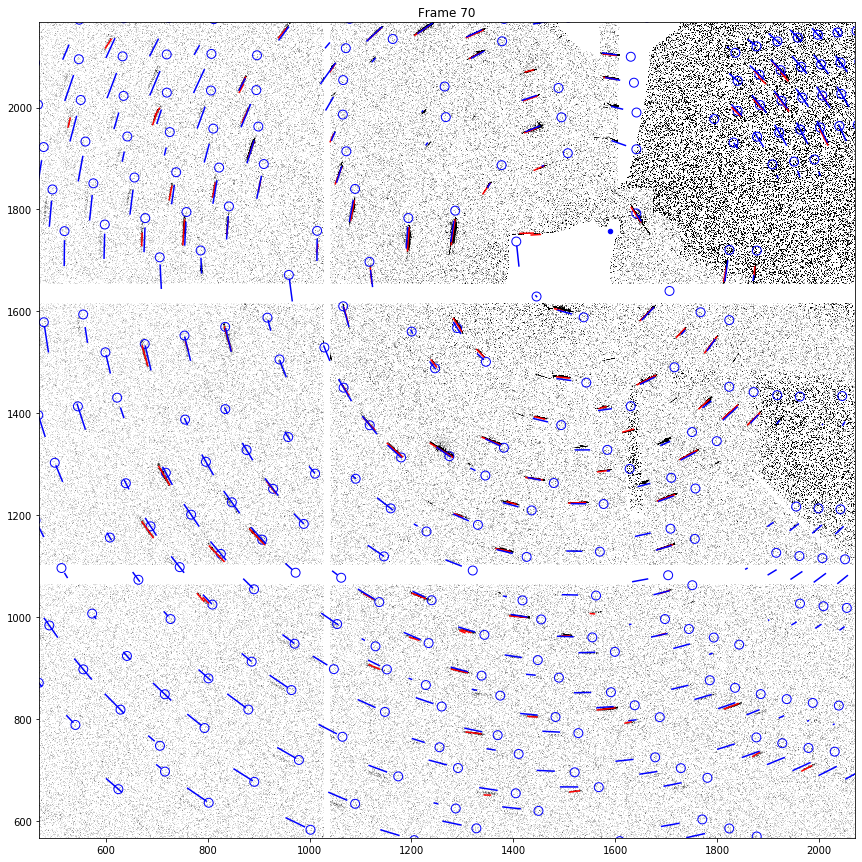

In [35]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx],
          vmin=0, vmax=20, cmap='gray_r')
for line in b12_scan[frame_idx].raw_lines:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
ax.scatter(b12_sset.smp_pos[0] / pix_size, b12_sset.smp_pos[1] / pix_size, 20, 'b')
ax.set_xlim(470, 2070)
ax.set_ylim(567, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/rot_model_10.pdf')

In [36]:
hkl_idxs = rot_tf.hkl_idxs(rot_ch)
model = cbc_dp.RectModel(rec_lat=cbc_dp.RecLattice(rot_tf.rec_basis(rot_ch), hkl_idxs),
                         kin=rot_tf.kin_bounds(rot_ch))
m_kout = model.kout()
m_kout_lines = model.kout_lines()
model_lines = rot_tf.det_kout(m_kout_lines[..., 0], m_kout_lines[..., 1], rot_ch)
model_pts = rot_tf.det_kout(m_kout[..., 0], m_kout[..., 1], rot_ch)
kins = rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None]

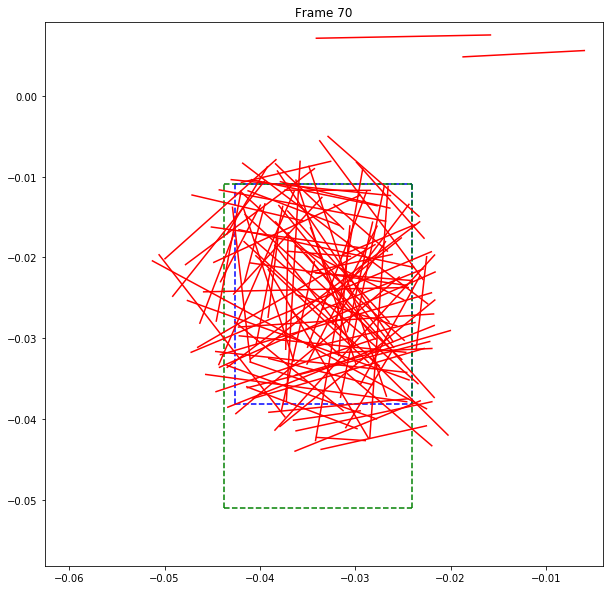

In [37]:
%matplotlib inline
kin = (b12_sset.pupil_bounds(0) - rot_ch[:2]) / rot_ch[2]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(np.linspace(model.kin[0, 0], model.kin[1, 0]), model.kin[0, 1] * np.ones(50), 'b--')
ax.plot(np.linspace(model.kin[0, 0], model.kin[1, 0]), model.kin[1, 1] * np.ones(50), 'b--')
ax.plot(model.kin[0, 0] * np.ones(50), np.linspace(model.kin[0, 1], model.kin[1, 1]), 'b--')
ax.plot(model.kin[1, 0] * np.ones(50), np.linspace(model.kin[0, 1], model.kin[1, 1]), 'b--')
ax.plot(np.linspace(kin[0, 0], kin[1, 0]), kin[0, 1] * np.ones(50), 'g--')
ax.plot(np.linspace(kin[0, 0], kin[1, 0]), kin[1, 1] * np.ones(50), 'g--')
ax.plot(kin[0, 0] * np.ones(50), np.linspace(kin[0, 1], kin[1, 1]), 'g--')
ax.plot(kin[1, 0] * np.ones(50), np.linspace(kin[0, 1], kin[1, 1]), 'g--')
for line in kins:
    ax.plot(line[:, 0], line[:, 1], 'r')
offset = 0.02
ax.set_xlim(model.kin[0, 0] - offset, model.kin[1, 0] + offset)
ax.set_ylim(model.kin[0, 1] - offset, model.kin[1, 1] + offset)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/full_pupil_10.pdf')

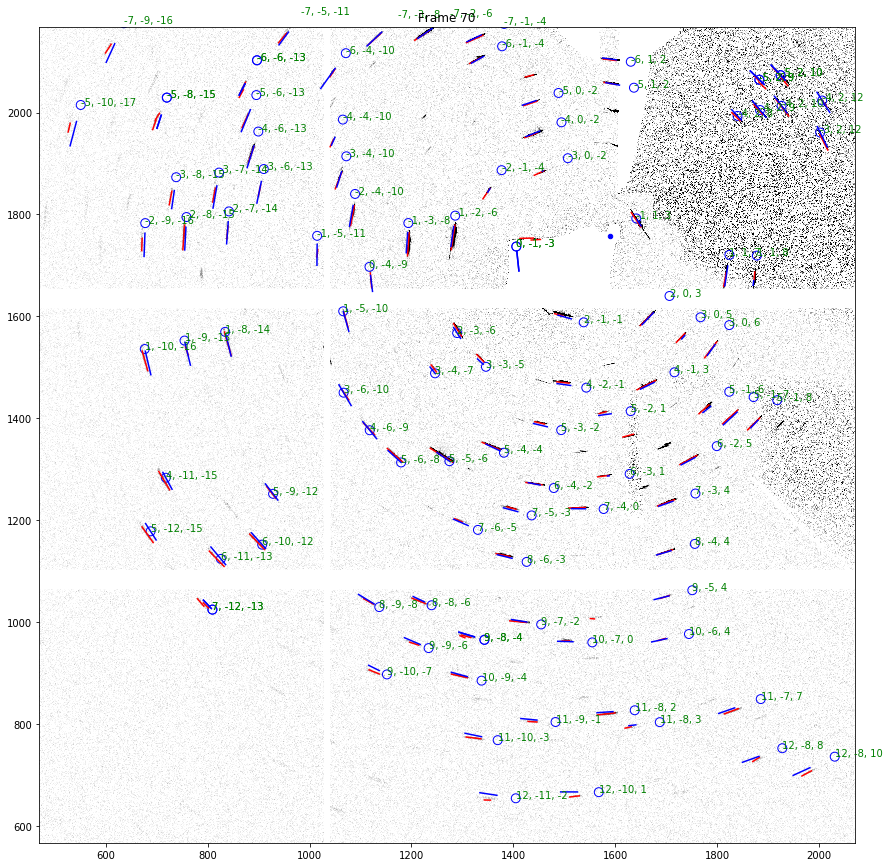

In [38]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
for line in b12_scan[frame_idx].raw_lines:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
ax.scatter(b12_sset.smp_pos[0] / pix_size, b12_sset.smp_pos[1] / pix_size, 20, 'b')
for pt, hkl in zip(model_pts, model.hkl_idxs):
    ax.text(pt[0], pt[1], '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl.astype(np.int)), color='g', fontsize=10)
ax.set_xlim(470, 2070)
ax.set_ylim(567, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/full_index_10.pdf')

In [6]:
scan, rb = b12_scan[20::20], rb_2
start_point = np.concatenate((rb.rb_mat.ravel(),
                              np.tile(b12_sset.smp_pos, scan.frames.size),
                              b12_sset.eul_ang[scan.frames].ravel()))
scan_tf = cbc_dp.ScanCBI(streaks=scan, rec_basis=rb, f_tol=(1e-2, 1e-2, 1e-3),
                         smp_tol=(5e-2, 5e-2, 5e-2), rb_tol=3e-3, ang_tol=0.1)
prob = pygmo.problem(scan_tf)
algo = pygmo.algorithm(pygmo.moead(gen=300, weight_generation='grid'))
algo.set_verbosity(25)

ps = cbc_dp.utils.scan_ps(2000, scan.frames.size)
pops = [pygmo.population(prob, size=ps, b=pygmo.mp_bfe()) for _ in range(12)]
archi = pygmo.archipelago()
for pop in pops:
    archi.push_back(algo=algo, pop=pop)
print(ps)

1820


In [7]:
archi.evolve()

In [36]:
# archi.wait()
ev_pops = [island.get_population() for island in archi]
index_sol = np.concatenate([pop.get_x() for pop in ev_pops])
index_pts = np.concatenate([pop.get_f() for pop in ev_pops])

In [37]:
rb = rb_2
archi = scan.rot_index(rec_basis=rb, n_isl=1, pop_size=50, gen_num=3000, f_tol=(1e-3, 1e-3, 1e-4),
                       smp_tol=(5e-2, 5e-2, 5e-2), rb_tol=1e-3, ang_tol=0.1)
archi.evolve()
archi.wait()
det_pos = np.concatenate([sol[3:6] for sol in archi.get_champions_x()])
eul_ang = np.concatenate([sol[9:] for sol in archi.get_champions_x()])
point = np.concatenate([f_pos, rb.rb_mat.ravel(), det_pos, eul_ang])

In [24]:
best_idx = np.argmin(index_pts.mean(axis=-1))
index_pts[best_idx], scan_tf.fitness(point)

NameError: name 'index_pts' is not defined

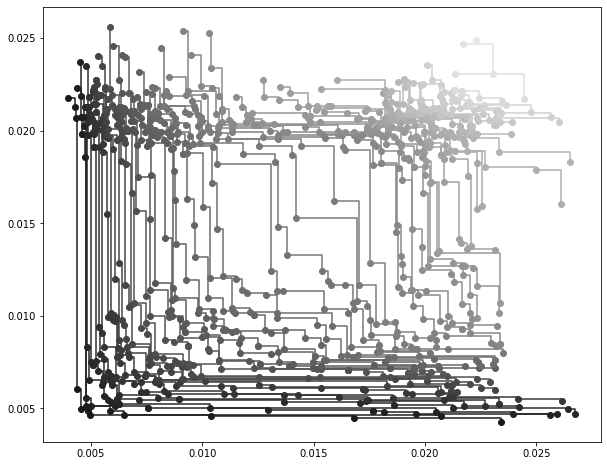

In [42]:
%matplotlib inline
plt.figure(figsize=(10, 8))
pygmo.plot_non_dominated_fronts(index_pts[:1000, 4:6])
plt.show()

# Indexing results

In [7]:
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file:
    ri_sol = ri_file['data/index_sol'][...]
    ri_pts = ri_file['data/index_pts'][...]
    rb = cbc_dp.RecBasis(ri_file['config/rb_mat'][...])
    f_tol = ri_file['config/f_tol'][...]
    smp_tol = ri_file['config/smp_tol'][...]
    rb_tol = ri_file['config/rb_tol'][...]
    ang_tol = ri_file['config/ang_tol'][...]
print(rb.rb_mat, smp_tol, f_tol, rb_tol)
idxs = (np.argmin(ri_pts, axis=0), np.arange(ri_sol.shape[1]))
ri_sol = ri_sol[idxs]

[[ 0.00822553 -0.04392742 -0.00112285]
 [ 0.03024139  0.00603186  0.00214177]
 [ 0.00255398  0.00087035 -0.02748237]] [0.05 0.05 0.08] [0.001  0.001  0.0001] 0.01


In [8]:
b12_sset = cbc_dp.ScanSetup.import_ini('b12_geom_02.ini')
with h5py.File(cor_path.format(135), 'r') as f135:
    b12_scan_new = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][...],
                                      exp_set=b12_sset,
                                      frame_idxs=f135['streaks/frame_idxs'][...])

In [10]:
kin_list, hkl_list = [], []
for frame_idx, (rot_ch, b12_frame) in enumerate(zip(ri_sol, b12_scan_new)):
    rot_tf = cbc_dp.RCBI(streaks=b12_frame, frame_idx=frame_idx, rec_basis=rb,
                         f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    hkl_list.append(rot_tf.hkl_idxs(rot_ch))
    kin_list.append(rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None])
kin_arr = np.concatenate(kin_list)
hkl_arr = np.concatenate(hkl_list)

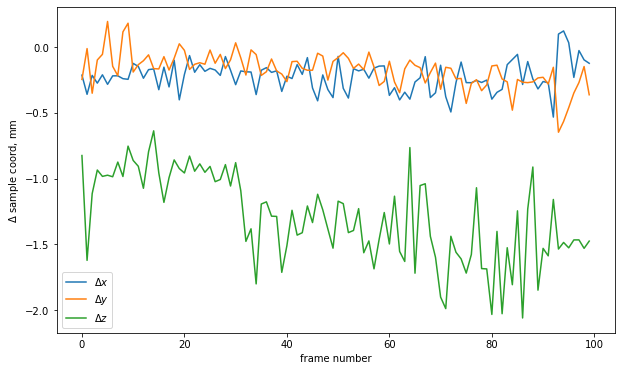

In [11]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(ri_sol[1:, 3] - b12_pos[0], label='$\Delta x$')
ax.plot(ri_sol[1:, 4] - b12_pos[1], label='$\Delta y$')
ax.plot(ri_sol[1:, 5] - b12_pos[2], label='$\Delta z$')
ax.set_xlabel('frame number')
ax.set_ylabel('$\Delta$ sample coord, mm')
ax.legend()
plt.show()
# plt.savefig('figures/rot_index_smp.pdf')

In [134]:
masks = []
for frame_idx, (rot_ch, b12_frame) in enumerate(zip(ri_sol, b12_scan_new)):
    rot_mat = b12_sset.rotation_matrix(frame_idx, inverse=True)
    rot_tf = cbc_dp.RCBI(streaks=b12_frame, frame_idx=frame_idx, rec_basis=rb,
                         f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    kin_arr = rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None]
    det_arr = rot_tf.det_kin(kin_arr[..., 0], kin_arr[..., 1], rot_ch)
    masks.append(cbc_dp.utils.streaks_mask(det_arr, np.ones((1, 1), dtype=np.uint8), 1, frame_shape[0], frame_shape[1]))
masks = np.stack(masks)[..., None] * np.array([1., 0., 0., 0.66])

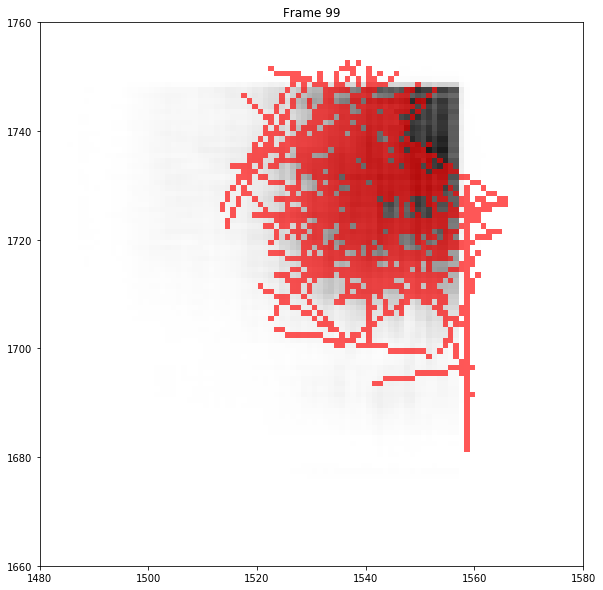

In [151]:
%matplotlib agg

from matplotlib import animation, rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))
im0 = ax.imshow([[]], extent=[0, frame_shape[1], frame_shape[0], 0], cmap='gray_r')
im1 = ax.imshow([[]], extent=[0, frame_shape[1], frame_shape[0], 0])
rc('animation', html='html5')

def init():
    ax.set_xlim(1480, 1580)
    ax.set_ylim(1660, 1760)
    im0.set_clim(400, 4000000)
    im1.set_clim(0, 1)
    return [im0, im1]

def animate1(i):
    ax.set_title("Frame {:d}".format(i))
    im0.set_data(b12_bgd[i])
    im1.set_data(masks[i])
    return [im0, im1]

pupil_mov = animation.FuncAnimation(fig, animate1, init_func=init, interval=100, frames=100, blit=True)
pupil_mov.save('pupil.mp4', extra_args=['-vcodec', 'libx264'])
# HTML(pupil_mov.to_html5_video())

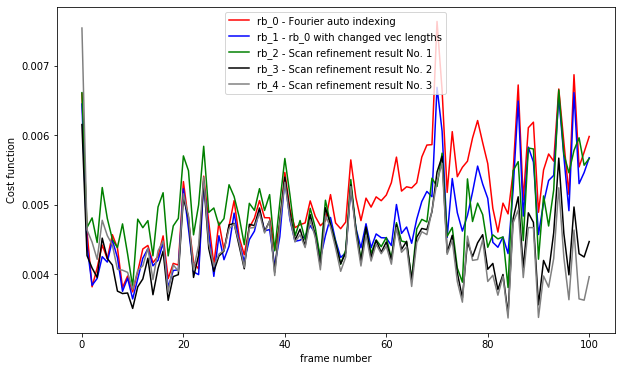

0.5116091189737537 0.4790558861772211 0.4914478568249739 0.4464263015554429 0.44473083667122976


In [10]:
%matplotlib inline
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
with h5py.File('exp_results/scan_00135/index/135_rot_index_00.h5', 'r') as ri_file0:
    ri_pts0 = ri_file0['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_01.h5', 'r') as ri_file1:
    ri_pts1 = ri_file1['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_02.h5', 'r') as ri_file2:
    ri_pts2 = ri_file2['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_03.h5', 'r') as ri_file3:
    ri_pts3 = ri_file3['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file4:
    ri_pts4 = ri_file4['data/index_pts'][...]
ax.plot(np.min(ri_pts0, axis=0), 'r', label='rb_0 - Fourier auto indexing')
ax.plot(np.min(ri_pts1, axis=0), 'b', label='rb_1 - rb_0 with changed vec lengths')
ax.plot(np.min(ri_pts2, axis=0), 'g', label='rb_2 - Scan refinement result No. 1')
ax.plot(np.min(ri_pts3, axis=0), 'black', label='rb_3 - Scan refinement result No. 2')
ax.plot(np.min(ri_pts4, axis=0), 'gray', label='rb_4 - Scan refinement result No. 3')
ax.legend()
ax.set_xlabel('frame number')
ax.set_ylabel('Cost function')
plt.show()
# plt.savefig('figures/fit_full.pdf')
print(np.min(ri_pts0, axis=0).sum(), np.min(ri_pts1, axis=0).sum(),
      np.min(ri_pts2, axis=0).sum(), np.min(ri_pts3, axis=0).sum(),
      np.min(ri_pts4, axis=0).sum())

0.053581006411241194 0.050155169470286 0.048834442560010044 0.04521139812220569 0.04433250959900623


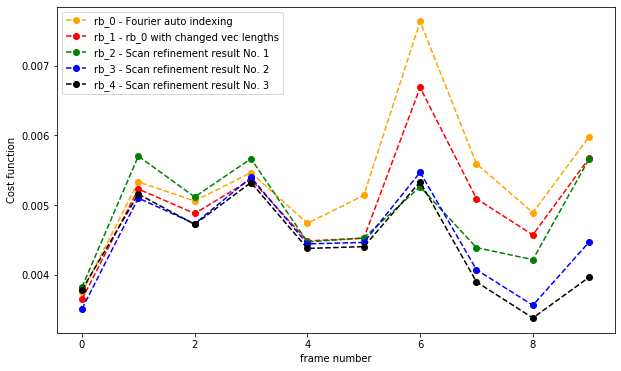

In [187]:
%matplotlib inline
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
with h5py.File('exp_results/scan_00135/index/135_rot_index_00.h5', 'r') as ri_file0:
    ri_pts0 = ri_file0['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_01.h5', 'r') as ri_file1:
    ri_pts1 = ri_file1['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_02.h5', 'r') as ri_file2:
    ri_pts2 = ri_file2['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_03.h5', 'r') as ri_file3:
    ri_pts3 = ri_file3['data/index_pts'][...]
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file4:
    ri_pts4 = ri_file4['data/index_pts'][...]
ax.plot(np.min(ri_pts0[:, 10::10], axis=0), color='orange', marker='o', linestyle='dashed',
        label='rb_0 - Fourier auto indexing')
ax.plot(np.min(ri_pts1[:, 10::10], axis=0), color='red', marker='o', linestyle='dashed',
        label='rb_1 - rb_0 with changed vec lengths')
ax.plot(np.min(ri_pts2[:, 10::10], axis=0), color='green', marker='o', linestyle='dashed',
        label='rb_2 - Scan refinement result No. 1')
ax.plot(np.min(ri_pts3[:, 10::10], axis=0), color='blue', marker='o', linestyle='dashed',
        label='rb_3 - Scan refinement result No. 2')
ax.plot(np.min(ri_pts4[:, 10::10], axis=0), color='black', marker='o', linestyle='dashed',
        label='rb_4 - Scan refinement result No. 3')
ax.legend()
ax.set_xlabel('frame number')
ax.set_ylabel('Cost function')
plt.show()
# plt.savefig('figures/fit_part.pdf')
print(np.min(ri_pts0, axis=0)[10::10].sum(), np.min(ri_pts1, axis=0)[10::10].sum(),
      np.min(ri_pts2, axis=0)[10::10].sum(), np.min(ri_pts3, axis=0)[10::10].sum(),
      np.min(ri_pts4, axis=0)[10::10].sum())

In [7]:
with h5py.File('exp_results/scan_00135/index/b12_index_full.h5', 'r') as fi_file:
    fi_sol = fi_file['data/index_sol'][...]
    fi_pts = fi_file['data/index_pts'][...]
idxs = (np.argmin(fi_pts, axis=0), np.arange(fi_sol.shape[1]))
fi_sol = fi_sol[idxs]

In [6]:
with h5py.File('exp_results/scan_00135/index/135_scan_index_03.h5', 'r') as scan_file:
    scan_sol = scan_file['data/index_sol'][...]
    scan_pts = scan_file['data/index_pts'][...]
    rb = cbc_dp.RecBasis(scan_file['config/rb_mat'][...])
    f_tol = scan_file['config/f_tol'][...]
    smp_tol = scan_file['config/smp_tol'][...]
    rb_tol = scan_file['config/rb_tol'][...]
    ang_tol = scan_file['config/ang_tol'][...]
    print(scan_file['config/gen_num'][...], scan_file['config/pop_size'][...])
best_idx = np.argmin(scan_pts.mean(axis=-1))
scan = b12_scan[10::10]
scan_tf = cbc_dp.ScanCBI(streaks=scan, rec_basis=rb, f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)

500 10000


In [7]:
archi = scan.rot_index(rec_basis=rb, n_isl=1, pop_size=50, gen_num=3000,
                       f_tol=(1e-3, 1e-3, 1e-3), smp_tol=smp_tol, rb_tol=1e-3, ang_tol=ang_tol)
archi.evolve()
archi.wait()
det_pos = np.concatenate([sol[3:6] for sol in archi.get_champions_x()])
eul_ang = np.concatenate([sol[9:] for sol in archi.get_champions_x()])
point = np.concatenate([f_pos, rb.rb_mat.ravel(), det_pos, eul_ang])

In [10]:
best_idx = np.argmin(scan_pts.mean(axis=-1))
scan_pts[best_idx], scan_tf.fitness(point), np.min(ri_pts, axis=0)[10::10]

(array([0.00631736, 0.00594553, 0.00582445, 0.00591047, 0.00512591,
        0.00457199, 0.00598446, 0.00448371, 0.00477481, 0.00493293]),
 array([0.00505572, 0.00706928, 0.00670878, 0.00702596, 0.00619366,
        0.00683802, 0.00958401, 0.0068433 , 0.00601576, 0.00748035]),
 array([0.00350682, 0.0051004 , 0.00473101, 0.00539759, 0.00444183,
        0.00446282, 0.00547052, 0.00407066, 0.00355988, 0.00446987]))

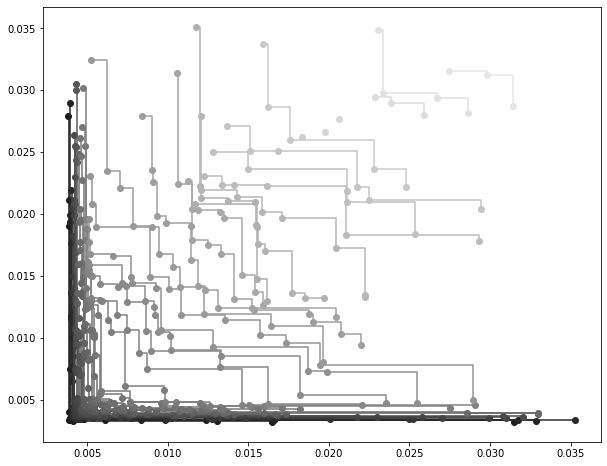

In [11]:
%matplotlib inline
idxs = np.random.choice(scan_pts.shape[0], 500)
plt.figure(figsize=(10, 8))
pygmo.plot_non_dominated_fronts(scan_pts[idxs, 7:9])
plt.show()

In [12]:
f_pos_new = scan_sol[best_idx, :3]
rb_new = cbc_dp.RecBasis(scan_sol[best_idx, 3:12].reshape((3, 3)))
b12_sset_new = cbc_dp.ScanSetup(pix_size=pix_size, smp_pos=b12_pos, f_pos=f_pos_new, pupil=b12_sset.pupil,
                                axis=axis, thetas=thetas)
with h5py.File(cor_path.format(135), 'r') as f135:
    b12_scan_new = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][...],
                                  exp_set=b12_sset_new,
                                  frame_idxs=f135['streaks/frame_idxs'][...])

In [41]:
b12_sset_new.save_ini('b12_geom_02.ini')
rb_new.save_ini('b12_rb_04.ini')

In [13]:
scan = b12_scan_new[10::10]
archi = scan.rot_index(rec_basis=rb_new, n_isl=1, pop_size=50, gen_num=3000,
                       f_tol=(1e-3, 1e-3, 1e-4), smp_tol=smp_tol, rb_tol=1e-2, ang_tol=ang_tol)
archi.evolve()
archi.wait()

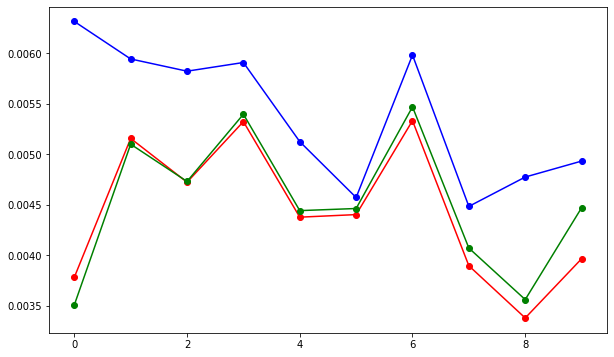

0.04433633911732211 0.0538716276027428 0.04521139812220569


In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.concatenate(archi.get_champions_f()), 'ro-')
ax.plot(scan_pts[best_idx], 'bo-')
ax.plot(np.min(ri_pts, axis=0)[10::10], 'go-')
plt.show()
print(np.concatenate(archi.get_champions_f()).sum(),
      scan_pts[best_idx].sum(), np.min(ri_pts, axis=0)[10::10].sum())

In [183]:
frame_idx = 99
with h5py.File('exp_results/scan_00135/index/135_rot_index_01.h5', 'r') as ri_file:
    idx = np.argmin(ri_file['data/index_pts'][:, frame_idx])
    sol = ri_file['data/index_sol'][idx, frame_idx]
    rb = cbc_dp.RecBasis(ri_file['config/rb_mat'][...])
    f_tol = ri_file['config/f_tol'][...]
    smp_tol = ri_file['config/smp_tol'][...]
    rb_tol = ri_file['config/rb_tol'][...]
    ang_tol = ri_file['config/ang_tol'][...]
rot_tf = cbc_dp.RCBI(streaks=b12_scan[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol,
                     pen_coeff=1.)

hkl_idxs = rot_tf.hkl_idxs(sol)
kins = rot_tf.kout_exp(sol) - rot_tf.rec_vectors(sol)[:, None]
frame_kin = rot_tf.kin_bounds(sol)
full_kin = (b12_sset.pupil_bounds(0) - sol[:2]) / sol[2]

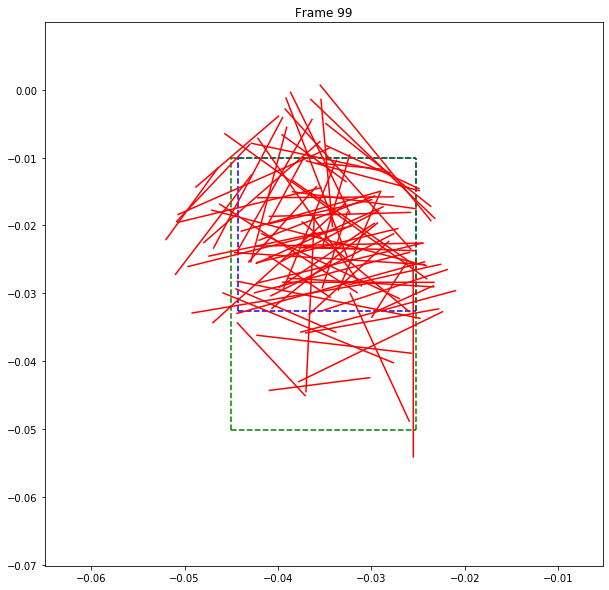

In [184]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[0, 1] * np.ones(50), 'b--')
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[1, 1] * np.ones(50), 'b--')
ax.plot(frame_kin[0, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(frame_kin[1, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[0, 1] * np.ones(50), 'g--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[1, 1] * np.ones(50), 'g--')
ax.plot(full_kin[0, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
ax.plot(full_kin[1, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
for line in kins:
    ax.plot(line[:, 0], line[:, 1], 'r')
offset = 0.02
ax.set_xlim(full_kin[0, 0] - offset, full_kin[1, 0] + offset)
ax.set_ylim(full_kin[0, 1] - offset, full_kin[1, 1] + offset)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/99_pupil_old.pdf')

In [185]:
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file:
    idx = np.argmin(ri_file['data/index_pts'][:, frame_idx])
    sol = ri_file['data/index_sol'][idx, frame_idx]
    rb = cbc_dp.RecBasis(ri_file['config/rb_mat'][...])
    f_tol = ri_file['config/f_tol'][...]
    smp_tol = ri_file['config/smp_tol'][...]
    rb_tol = ri_file['config/rb_tol'][...]
    ang_tol = ri_file['config/ang_tol'][...]
rot_tf = cbc_dp.RCBI(streaks=b12_scan_new[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol, pen_coeff=1.)

hkl_idxs = rot_tf.hkl_idxs(sol)
kins = rot_tf.kout_exp(sol) - rot_tf.rec_vectors(sol)[:, None]
frame_kin = rot_tf.kin_bounds(sol)
full_kin = (b12_sset.pupil_bounds(0) - sol[:2]) / sol[2]

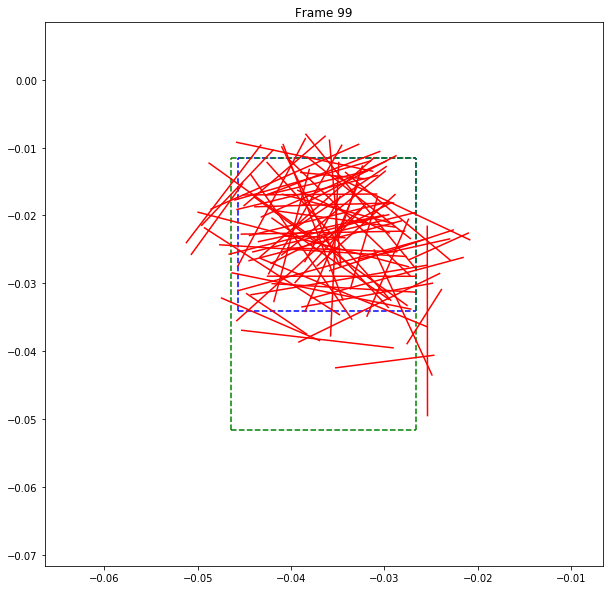

In [186]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[0, 1] * np.ones(50), 'b--')
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[1, 1] * np.ones(50), 'b--')
ax.plot(frame_kin[0, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(frame_kin[1, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[0, 1] * np.ones(50), 'g--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[1, 1] * np.ones(50), 'g--')
ax.plot(full_kin[0, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
ax.plot(full_kin[1, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
for line in kins:
    ax.plot(line[:, 0], line[:, 1], 'r')
offset = 0.02
ax.set_xlim(full_kin[0, 0] - offset, full_kin[1, 0] + offset)
ax.set_ylim(full_kin[0, 1] - offset, full_kin[1, 1] + offset)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()
# plt.savefig('figures/99_pupil_new.pdf')

# Sample rotation

In [6]:
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file:
    idxs = (np.argmin(ri_file['data/index_pts'][...], axis=0), np.arange(ri_file['data/index_sol'].shape[1]))
    ri_sol = ri_file['data/index_sol'][...][idxs]
    rb = cbc_dp.RecBasis(ri_file['config/rb_mat'][...])
    f_tol = ri_file['config/f_tol'][...]
    smp_tol = ri_file['config/smp_tol'][...]
    rb_tol = ri_file['config/rb_tol'][...]
    ang_tol = ri_file['config/ang_tol'][...]

In [7]:
eul_ang = ri_sol[:, 9:]
rot_mats = np.array([cbc_dp.utils.euler_matrix(ang[0], ang[1], ang[2]) for ang in eul_ang])

In [20]:
rel_rots = []
for rot1, rot0 in zip(rot_mats[1:], rot_mats[:-1]):
    rel_rots.append(rot1 @ np.linalg.inv(rot0))
rel_rots = np.stack(rel_rots)
exp_th = np.arccos((np.trace(rel_rots, axis1=1, axis2=2) - 1) / 2)

In [21]:
ux = rel_rots[:, 2, 1] - rel_rots[:, 1, 2]
uy = rel_rots[:, 0, 2] - rel_rots[:, 2, 0]
uz = rel_rots[:, 1, 0] - rel_rots[:, 0, 1]
u = np.stack([ux, uy, uz], axis=-1)
u = u / np.sqrt((u**2).sum(axis=-1))[:, None]
u_th = np.arccos(u[:, 1])
u_phi = np.arctan2(ux, uz)

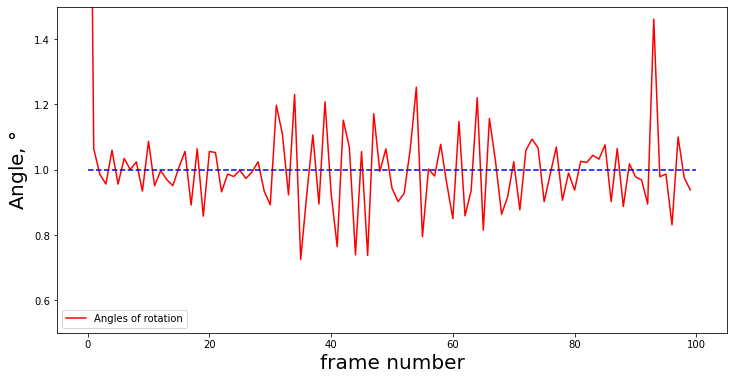

In [24]:
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.degrees(exp_th), 'r', label='Angles of rotation')
ax.plot(np.ones(101), 'b--')
ax.legend()
ax.set_ylim(0.5, 1.5)
ax.set_xlabel('frame number', fontsize=20)
ax.set_ylabel('Angle, $\degree$', fontsize=20)
plt.show()
# plt.savefig('figures/ang_rot.pdf')

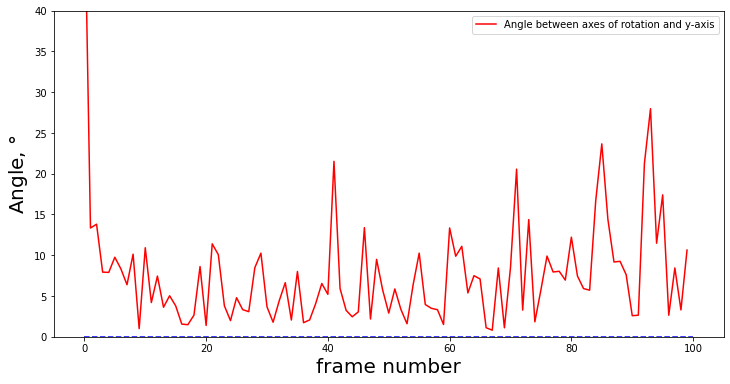

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(np.degrees(np.pi - u_th), 'r', label='Angle between axes of rotation and y-axis')
ax.plot(np.zeros(101), 'b--')
ax.legend()
ax.set_ylim(0, 40)
ax.set_xlabel('frame number', fontsize=20)
ax.set_ylabel('Angle, $\degree$', fontsize=20)
plt.show()
# plt.savefig('figures/ax_rot.pdf')

## Intensity estimation

In [6]:
b12_sset = cbc_dp.ScanSetup.import_ini('b12_geom_02.ini')
with h5py.File(cor_path.format(135), 'r') as f135:
    b12_scan_new = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][...],
                                      exp_set=b12_sset,
                                      frame_idxs=f135['streaks/frame_idxs'][...])

In [7]:
with h5py.File('exp_results/scan_00135/index/135_rot_index_04.h5', 'r') as ri_file:
    ri_sol = ri_file['data/index_sol'][...]
    ri_pts = ri_file['data/index_pts'][...]
    rb = cbc_dp.RecBasis(ri_file['config/rb_mat'][...])
    f_tol = ri_file['config/f_tol'][...]
    smp_tol = ri_file['config/smp_tol'][...]
    rb_tol = ri_file['config/rb_tol'][...]
    ang_tol = ri_file['config/ang_tol'][...]
idxs = (np.argmin(ri_pts, axis=0), np.arange(ri_sol.shape[1]))
ri_sol = ri_sol[idxs]

In [8]:
kin_list, hkl_list, kout_list = [], [], []
for frame_idx, (rot_ch, b12_frame) in enumerate(zip(ri_sol, b12_scan_new)):
    rot_tf = cbc_dp.RCBI(streaks=b12_frame, frame_idx=frame_idx, rec_basis=rb,
                         f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    kout_list.append(rot_tf.kout_exp(rot_ch))
    hkl_list.append(rot_tf.hkl_idxs(rot_ch))
    kin_list.append(rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None])
kout_arr = np.concatenate(kout_list)
kin_arr = np.concatenate(kin_list)
hkl_arr = np.concatenate(hkl_list)

In [14]:
c0_list, c1_list = [], []
for i0, i1, i2 in zip(b12_scan_new.idxs[:-2], b12_scan_new.idxs[1:-1], b12_scan_new.idxs[2:]):
    hkl0, hkl1 = hkl_arr[i0:i1], hkl_arr[i1:i2]
    c0, c1 = np.where((hkl0[:, None] == hkl1[None, :]).all(axis=-1))
    c0_list.append(c0)
    c1_list.append(c1)

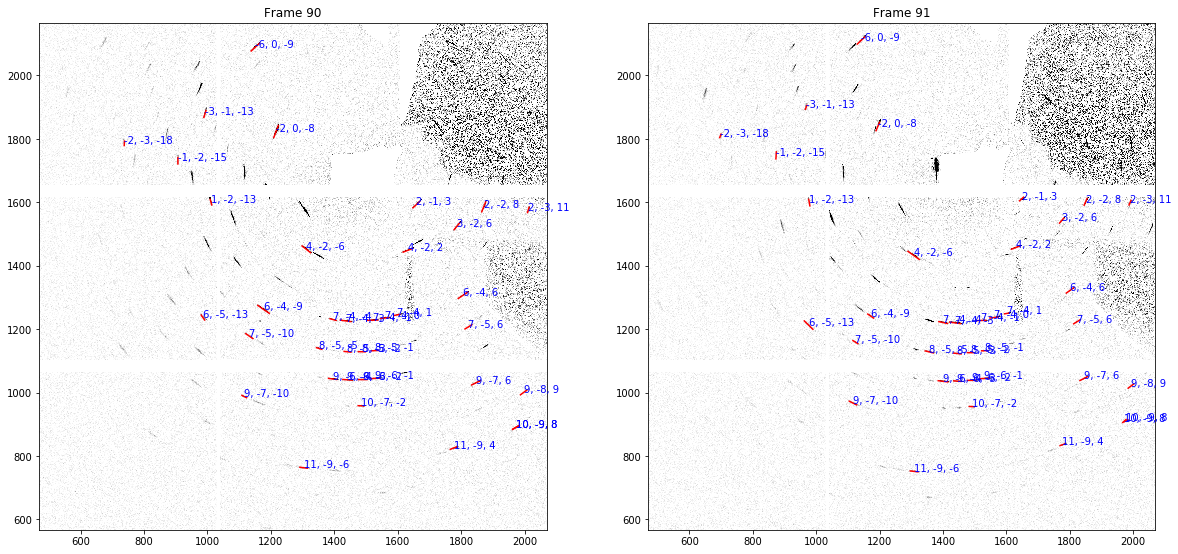

In [156]:
%matplotlib inline
frame_idx = 90
hkl0 = hkl_arr[b12_scan.idxs[frame_idx]:b12_scan.idxs[frame_idx + 1]][c0_list[frame_idx]]
hkl1 = hkl_arr[b12_scan.idxs[frame_idx + 1]:b12_scan.idxs[frame_idx + 2]][c1_list[frame_idx]]
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
axes[1].imshow(b12_cor_data[frame_idx + 1], vmin=0, vmax=50, cmap='gray_r')
for hkl, line in zip(hkl0, b12_scan[frame_idx].raw_lines[c0_list[frame_idx]]):
    axes[0].plot(line[:, 0], line[:, 1], 'r')
    axes[0].text(line[..., 0].mean(), line[..., 1].mean(),
                 '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color='b')
for hkl, line in zip(hkl1, b12_scan[frame_idx + 1].raw_lines[c1_list[frame_idx]]):
    axes[1].plot(line[:, 0], line[:, 1], 'r')
    axes[1].text(line[..., 0].mean(), line[..., 1].mean(),
                 '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color='b')
for ax, frame_idx in zip(axes, [frame_idx, frame_idx + 1]):
    ax.set_xlim(470, 2070)
    ax.set_ylim(567, 2167)
    ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

# Frame streaks merging

In [8]:
idxs_list = []
for frame_idx, (rot_ch, b12_frame) in enumerate(zip(ri_sol, b12_scan_new)):
    rot_tf = cbc_dp.RCBI(streaks=b12_frame, frame_idx=frame_idx, rec_basis=rb,
                         f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    idxs_list.append(cbc_dp.utils.reduce_frame(rot_tf.kout_exp(rot_ch), rot_tf.hkl_idxs(rot_ch).astype(np.float64),
                                  rot_tf.rb_mat(rot_ch), rot_tf.kin_bounds(rot_ch), 1.))

In [9]:
b12_scan_r = cbc_dp.ScanStreaks.import_series([b12_frame[idxs] for b12_frame, idxs in zip(b12_scan_new, idxs_list)])
b12_scan.size, b12_scan_r.size

(13099, 12237)

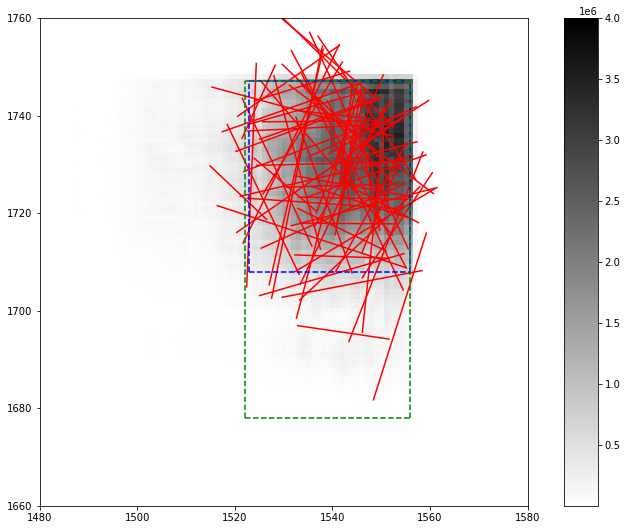

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

frame_idx = 100
rot_tf = cbc_dp.RCBI(streaks=b12_scan_r[frame_idx], frame_idx=frame_idx, rec_basis=rb,
                     f_tol=f_tol, smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
kin_frame = rot_tf.kout_exp(ri_sol[frame_idx]) - rot_tf.rec_vectors(ri_sol[frame_idx])[:, None]
det_frame = rot_tf.det_kin(kin_frame[..., 0], kin_frame[..., 1], ri_sol[frame_idx])
frame_kin = rot_tf.det_kin(rot_tf.kin_bounds(ri_sol[frame_idx])[:, 0],
                           rot_tf.kin_bounds(ri_sol[frame_idx])[:, 1],
                           ri_sol[frame_idx])
full_kin = b12_sset.pupil_bounds(0) / pix_size

%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.imshow(b12_bgd[frame_idx], vmin=400, vmax=4000000, cmap='gray_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.5)
fig.colorbar(im, cax=cax)
for line in det_frame:
    ax.plot(line[:, 0], line[:, 1], 'r')
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[0, 1] * np.ones(50), 'b--')
ax.plot(np.linspace(frame_kin[0, 0], frame_kin[1, 0]), frame_kin[1, 1] * np.ones(50), 'b--')
ax.plot(frame_kin[0, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(frame_kin[1, 0] * np.ones(50), np.linspace(frame_kin[0, 1], frame_kin[1, 1]), 'b--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[0, 1] * np.ones(50), 'g--')
ax.plot(np.linspace(full_kin[0, 0], full_kin[1, 0]), full_kin[1, 1] * np.ones(50), 'g--')
ax.plot(full_kin[0, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
ax.plot(full_kin[1, 0] * np.ones(50), np.linspace(full_kin[0, 1], full_kin[1, 1]), 'g--')
ax.set_xlim(1480, 1580)
ax.set_ylim(1660, 1760)
plt.show()
# plt.savefig('figures/source_streaks_r.pdf')

# Streaks merging

In [10]:
def res_sort(rb_mat, hkl_arr, is_arr):
    rec_vec = hkl_arr[:, :3].dot(rb_mat)
    sort_idxs = np.argsort((rec_vec**2).sum(axis=-1))
    return hkl_arr[sort_idxs], is_arr[sort_idxs]

def rec_abs(rb_mat, hkl_arr, wavelength=wavelength):
    rec_vec = hkl_arr[:, :3].dot(rb_mat)
    return ((rec_vec)**2).sum(axis=-1) / wavelength * 1e-7

In [12]:
is_list, hkl_list, dkin_list = [], [], []
for frame_idx, b12_frame, rot_ch in zip(b12_scan_r.frames, b12_scan_r, ri_sol):
    rot_tf = cbc_dp.RCBI(b12_frame, frame_idx=frame_idx, rec_basis=rb, f_tol=f_tol,
                         smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    kin_frame = rot_tf.kout_exp(rot_ch) - rot_tf.rec_vectors(rot_ch)[:, None]
    det_frame = rot_tf.det_kin(kin_frame[..., 0], kin_frame[..., 1], rot_ch)
    is_list.append(cbc_dp.utils.i_sigma_norm(b12_frame.raw_lines, det_frame, b12_cor_data[frame_idx],
                                             b12_bgd[frame_idx], cbc_dp.utils.STRUCT, 5))
    hkl_list.append(rot_tf.hkl_idxs(rot_ch))
    dkin_list.append(det_frame)
is_arr = np.concatenate(is_list)
hkl_arr = np.concatenate(hkl_list)
dkin_arr = np.concatenate(dkin_list)

In [154]:
is_list, hkl_list = [], []
for frame_idx, b12_frame, rot_ch in zip(b12_scan_r.frames, b12_scan_r, ri_sol):
    rot_tf = cbc_dp.RCBI(b12_frame, frame_idx=frame_idx, rec_basis=rb, f_tol=f_tol,
                         smp_tol=smp_tol, rb_tol=rb_tol, ang_tol=ang_tol)
    is_list.append(cbc_dp.utils.i_sigma(b12_frame.raw_lines, b12_cor_data[frame_idx],
                                        b12_bgd[frame_idx], cbc_dp.utils.STRUCT, 5))
    hkl_list.append(rot_tf.hkl_idxs(rot_ch))
is_arr = np.concatenate(is_list)
hkl_arr = np.concatenate(hkl_list)

In [13]:
import spglib

h_num = 115
rot_ops = spglib.get_symmetry_from_database(h_num)['rotations'].astype(np.int64)

In [14]:
hkl_m, is_m = cbc_dp.utils.merge(hkl_arr, is_arr)
hkl_sym, is_sym = cbc_dp.utils.symmetry_merge(rot_ops, hkl_arr, is_arr)
hkl_m.shape, hkl_sym.shape

((5421, 4), (3798, 4))

In [15]:
hkl_m, is_m = res_sort(rb.rb_mat, hkl_m, is_m)
hkl_sym, is_sym = res_sort(rb.rb_mat, hkl_sym, is_sym)
res_m = rec_abs(rb.rb_mat, hkl_m)
res_sym = rec_abs(rb.rb_mat, hkl_sym)

In [16]:
i_idx, f_idx = 1000, 1030
for hkl_val, is_val, res_val in zip(hkl_m[i_idx:f_idx], is_m[i_idx:f_idx], res_m[i_idx:f_idx]):
    print('{0[0]:4d},{0[1]:4d},{0[2]:4d}:{0[3]:6d}{1[0]:16.4e}{1[1]:16.4e}{2:8.2f}'.format(hkl_val,
                                                                                           is_val,
                                                                                           res_val))

   5,  -2,   5:     2      2.9031e-06      4.5739e-07    0.10
  -2,   4,   8:     1      2.0929e-05      1.7583e-06    0.10
   2,  -4,  -8:     1      1.6553e-05      4.3552e-07    0.10
   1,  -3,  -9:     1      6.0768e-06      4.8769e-07    0.10
   4,   6,   3:     1      3.8760e-06      1.3071e-07    0.10
  -4,  -6,  -3:     1      3.6935e-06      8.9525e-08    0.10
   4,  -2,   7:     2      6.0819e-06      7.5878e-07    0.10
   5,   2,   5:     2      3.0054e-06      3.2465e-07    0.10
  -5,  -2,  -5:     3      2.4545e-06      4.3538e-07    0.10
  -6,  -1,  -1:     7      1.1877e-05      1.7928e-06    0.10
  -2,  -4,  -8:     2      1.8510e-05      8.4281e-06    0.10
   0,   6,   7:     1      3.4889e-05      3.6595e-06    0.10
   0,  -6,  -7:     1      1.6852e-05      2.6441e-07    0.10
  -6,   1,   1:     2      4.6685e-05      5.8589e-06    0.10
  -1,  -3,  -9:     2      7.7248e-06      2.5239e-05    0.10
  -5,  -5,  -1:     2      7.6509e-06      7.9616e-07    0.10
  -2,   

In [17]:
i_idx, f_idx = 1000, 1030
for hkl_val, is_val, res_val in zip(hkl_sym[i_idx:f_idx], is_sym[i_idx:f_idx], res_sym[i_idx:f_idx]):
    print('{0[0]:4d},{0[1]:4d},{0[2]:4d}:{0[3]:6d}{1[0]:16.4e}{1[1]:16.4e}{2:8.2f}'.format(hkl_val,
                                                                                           is_val,
                                                                                           res_val))

  -1,  -6, -10:     1      2.3637e-06      9.7412e-08    0.16
  -5,   2,   9:     5      8.5637e-06      1.4648e-06    0.16
  -6,   4,   6:     8      1.7003e-05      4.9430e-06    0.16
   6,   5,   5:     6      1.3549e-05      2.0182e-06    0.16
   3,   2,  11:     5      4.6971e-06      6.4440e-07    0.16
  -3,  -2, -11:     3      4.3466e-06      1.6445e-06    0.16
   0, -11,   1:     2      1.0995e-05      5.1706e-06    0.16
   6,   4,   6:     6      1.6025e-05      2.3006e-06    0.16
  -5,  -4,  -8:     2      3.8979e-06      1.1353e-06    0.16
   5,   4,   8:     4      5.6928e-06      8.4928e-07    0.16
   3,   7,   8:     4      3.0985e-05      2.8450e-06    0.16
   5,  -8,  -2:     4      1.6859e-05      3.0004e-06    0.16
  -6,   5,   5:     7      1.4668e-05      2.9201e-06    0.16
  -3,   7,   8:     4      2.2867e-05      7.4556e-06    0.16
   4,   9,   3:     4      5.0984e-06      1.9912e-06    0.16
  -3,   6,   9:     2      6.5802e-06      1.8098e-06    0.16
   3,   

In [29]:
hkl_list = cbc_dp.utils.HKLList(hkl_sym, is_sym / is_sym[:, 0].min())
hkl_list.save_txt('exp_results/scan_00135/b12_hkl.pdb.hkl')

In [18]:
d_res = 0.1
limits = d_res * np.arange(res_sym.min() // d_res, res_sym.max() // d_res + 1)
sects = np.unique(np.searchsorted(limits, res_sym), return_index=True)[1]
hkl_list = np.split(hkl_sym[:, :3], indices_or_sections=sects[1:])
cnts_list = np.split(hkl_sym[:, 3], indices_or_sections=sects[1:])
is_list = np.split(is_sym, indices_or_sections=sects[1:])
abs_list = np.split(res_sym, indices_or_sections=sects[1:])

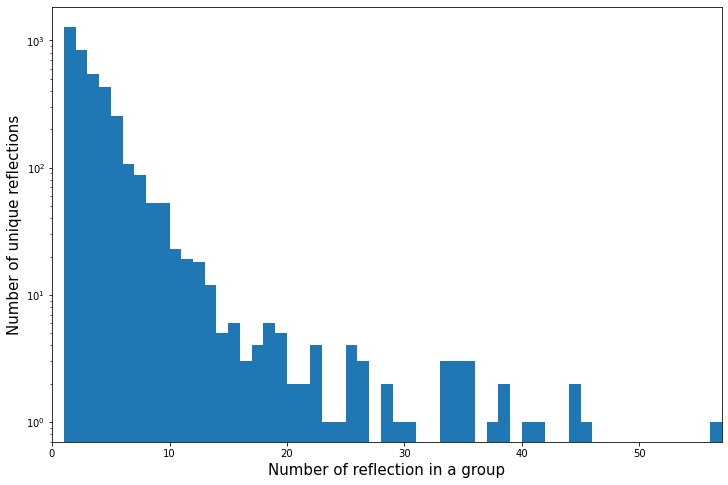

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.hist(hkl_sym[:, 3], bins=np.arange(0, hkl_sym[:, 3].max() + 1), log=True)
ax.set_xlabel('Number of reflection in a group', fontsize=15)
ax.set_ylabel('Number of unique reflections', fontsize=15)
ax.set_xlim(0, hkl_sym[:, 3].max())
plt.show()
# plt.savefig('figures/hkl_hist.pdf')

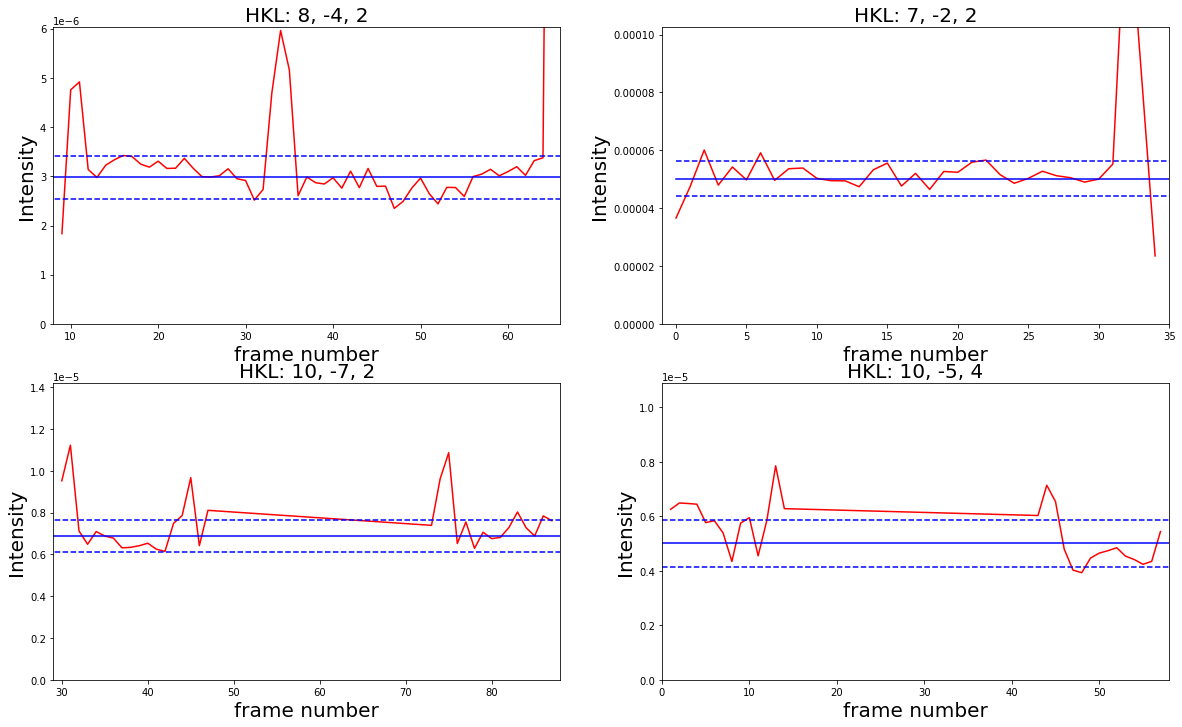

In [20]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
sort_idxs = np.argsort(hkl_m[:, 3])[::-1]
for idx, ax in zip([0, 5, 10, 15], axes.ravel()):
    hkl_max = hkl_m[sort_idxs[idx], :3]
    idxs = np.where((hkl_arr == hkl_max).all(axis=-1))[0]
    ax.plot(b12_scan_r.frame_idxs[idxs], is_arr[idxs, 0], 'r')
    ax.plot(np.arange(b12_sset.scan_size), is_m[sort_idxs[idx], 0] * np.ones(b12_sset.scan_size), 'b')
    ax.plot(np.arange(b12_sset.scan_size),
            (is_m[sort_idxs[idx], 0] + is_m[sort_idxs[idx], 1]) * np.ones(b12_sset.scan_size), 'b--')
    ax.plot(np.arange(b12_sset.scan_size),
            (is_m[sort_idxs[idx], 0] - is_m[sort_idxs[idx], 1]) * np.ones(b12_sset.scan_size), 'b--')
    ax.set_xlim(b12_scan_r.frame_idxs[idxs].min() - 1, b12_scan_r.frame_idxs[idxs].max() + 1)
    ax.set_ylim(0, 2 * np.median(is_arr[idxs, 0]))
    ax.set_xlabel('frame number', fontsize=20)
    ax.set_ylabel('Intensity', fontsize=20)
    ax.set_title('HKL: {0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl_max), fontsize=20)
# plt.show()
plt.savefig('figures/hkl_int_norm.pdf')

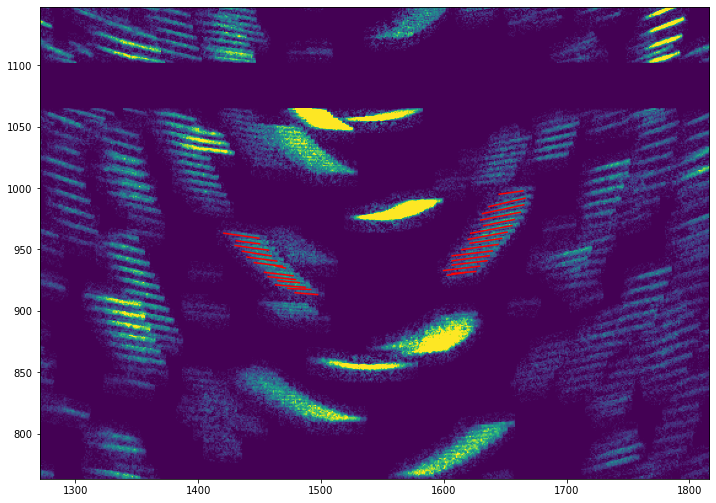

In [21]:
%matplotlib inline
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
idxs = np.where((hkl_arr == hkl_max).all(axis=-1))[0][1:]
lines = b12_scan_r.raw_lines[idxs]
for line in lines:
    ax.plot(line[:, 0], line[:, 1], 'r')
ax.imshow((b12_cor_data[b12_scan_r.frame_idxs[idxs]] * b12_streaks_mask[b12_scan_r.frame_idxs[idxs]]).sum(axis=0),
          vmin=0, vmax=100)
offset = 150
ax.set_xlim(lines[..., 0].min() - offset, lines[..., 0].max() + offset)
ax.set_ylim(lines[..., 1].min() - offset, lines[..., 1].max() + offset)
plt.show()

In [24]:
hkl1_m, is1_m = cbc_dp.utils.symmetry_merge(sym_ops=rot_ops,
                                            hkl_arr=np.ascontiguousarray(hkl_arr[::2]),
                                            is_arr=np.ascontiguousarray(is_arr[::2]))
hkl2_m, is2_m = cbc_dp.utils.symmetry_merge(sym_ops=rot_ops,
                                            hkl_arr=np.ascontiguousarray(hkl_arr[1::2]),
                                            is_arr=np.ascontiguousarray(is_arr[1::2]))
cidxs1, cidxs2 = np.where((hkl1_m[:, None, :3] == hkl2_m[None, :, :3]).all(axis=-1))
i1_c, i2_c = is1_m[cidxs1, 0], is2_m[cidxs2, 0]
r_split = np.abs(i1_c - i2_c).sum() / (i1_c + i2_c).sum() * np.sqrt(2)
print(r_split)

0.29015674502598066


In [25]:
hkl_mult = hkl_sym[hkl_sym[:, 3] > 6]
idxs_mult = np.where((hkl_arr[:, None, :3] == hkl_mult[None, :, :3]).all(axis=-1).any(axis=1))
hkl_mult, is_mult = hkl_arr[idxs_mult], is_arr[idxs_mult]

In [26]:
hkl1_m, i1_m = cbc_dp.utils.symmetry_merge(sym_ops=rot_ops,
                                           hkl_arr=np.ascontiguousarray(hkl_mult[::2]),
                                           is_arr=np.ascontiguousarray(is_mult[::2]))
hkl2_m, i2_m = cbc_dp.utils.symmetry_merge(sym_ops=rot_ops,
                                           hkl_arr=np.ascontiguousarray(hkl_mult[1::2]),
                                           is_arr=np.ascontiguousarray(is_mult[1::2]))
cidxs1, cidxs2 = np.where((hkl1_m[:, None, :3] == hkl2_m[None, :, :3]).all(axis=-1))
i1_c, i2_c = i1_m[cidxs1], i2_m[cidxs2]
r_split = np.abs(i1_c - i2_c).sum() / (i1_c + i2_c).sum() * np.sqrt(2)
print(r_split)

0.44887405922510165
